In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [3]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)

def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None

def preprocess_image(image, image_size=(224, 224)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.1, ela_resized, 0.9, 0)

In [4]:
def prepare_dataset(dataset_path, image_size=(224, 224), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [6]:
def build_model(image_size=(224, 224)):
    """Build and compile a MobileNetV2-based model."""
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_tensor=input_tensor
    )
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    x = Flatten()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.6)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"],
    )

    return model

In [7]:
def train_model(model, X, y, epochs=50):
    """Train the model with optimized parameters and class weighting."""
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=42,
        # callbacks=[early_stopping, lr_scheduler],
    )
    return model, history, X_test, y_test

In [8]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

In [9]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history['accuracy']) * 100, label='Train Accuracy')
    ax[0].plot(np.array(history.history['val_accuracy']) * 100, label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(history.history['loss'] , label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    ax[2].plot(np.array(history.history['AUC']) * 100, label='Train AUC')
    ax[2].plot(np.array(history.history['val_AUC']) * 100, label='Val AUC')
    ax[2].set_title('AUC Score')
    ax[2].set_ylabel('AUC (%)')
    ax[2].set_xlabel('Epoch')
    ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

In [10]:
# Step 1: Build model
image_size = (224, 224)
model = build_model(image_size)

/var/folders/rz/1_0vymm50cxb84f_6l23t6j80000gn/T/ipykernel_36711/3909597676.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [11]:
# Step 2: Define dataset path and image size
dataset_path = r"./CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [13]:
# Step 4: Train model
model, history, X_test, y_test = train_model(model, X, y, epochs=25)


(10091, 224, 224, 3) (10091,)
(1261, 224, 224, 3) (1261,)
(1262, 224, 224, 3) (1262,)
Epoch 1/25


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


241/241 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - AUC: 0.7841 - accuracy: 0.7268 - loss: 0.7458 - val_AUC: 0.9241 - val_accuracy: 0.8637 - val_loss: 0.3629
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - AUC: 0.9096 - accuracy: 0.8384 - loss: 0.4017 - val_AUC: 0.9345 - val_accuracy: 0.8661 - val_loss: 0.3232
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - AUC: 0.9348 - accuracy: 0.8664 - loss: 0.3300 - val_AUC: 0.9383 - val_accuracy: 0.8693 - val_loss: 0.3114
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - AUC: 0.9532 - accuracy: 0.8862 - loss: 0.2736 - val_AUC: 0.9409 - val_accuracy: 0.8566 - val_loss: 0.3190
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - AUC: 0.9603 - accuracy: 0.8996 - loss: 0.2505 - val_AUC: 0.9432 - val_accuracy: 0.8716 - val_loss: 0.3029
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - AUC: 0.9670 - accuracy: 0.9081 - loss: 0.2268 - val_AUC: 0.9455 - val_accuracy: 0.8653 - val_loss: 0.3137
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 253s 

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - AUC: 0.9384 - accuracy: 0.8837 - loss: 0.4787


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step

Test Metrics:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       749
           1       0.86      0.88      0.87       512

    accuracy                           0.89      1261
   macro avg       0.89      0.89      0.89      1261
weighted avg       0.89      0.89      0.89      1261



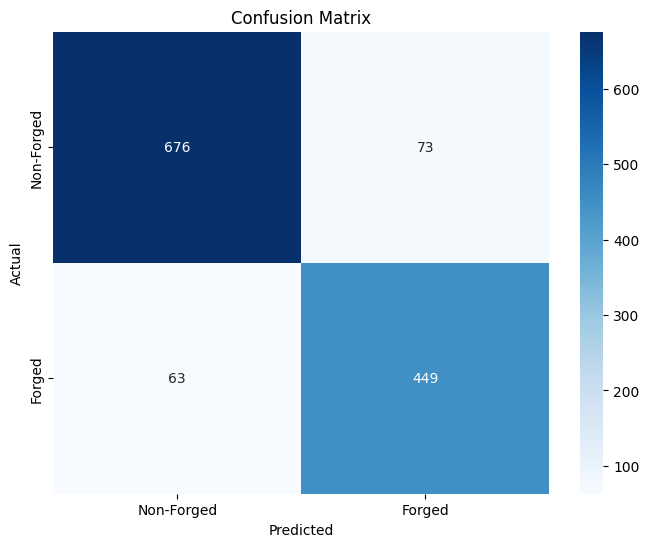

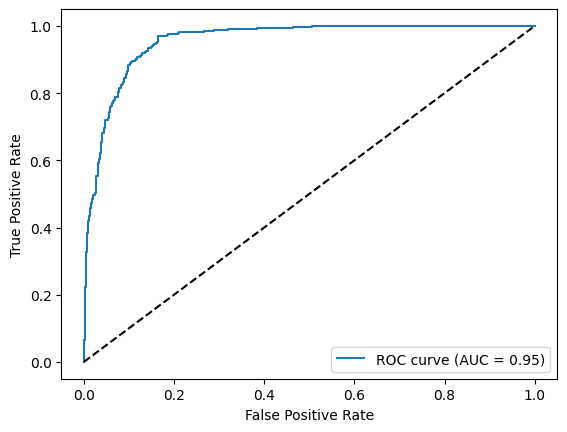

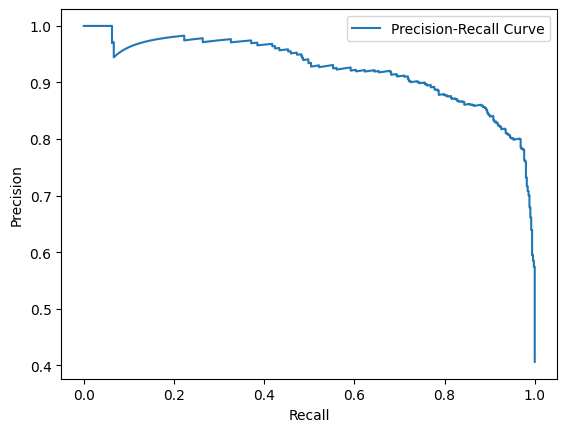

In [14]:

# Step 5: Evaluate model
evaluate_model(model, X_test, y_test)

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


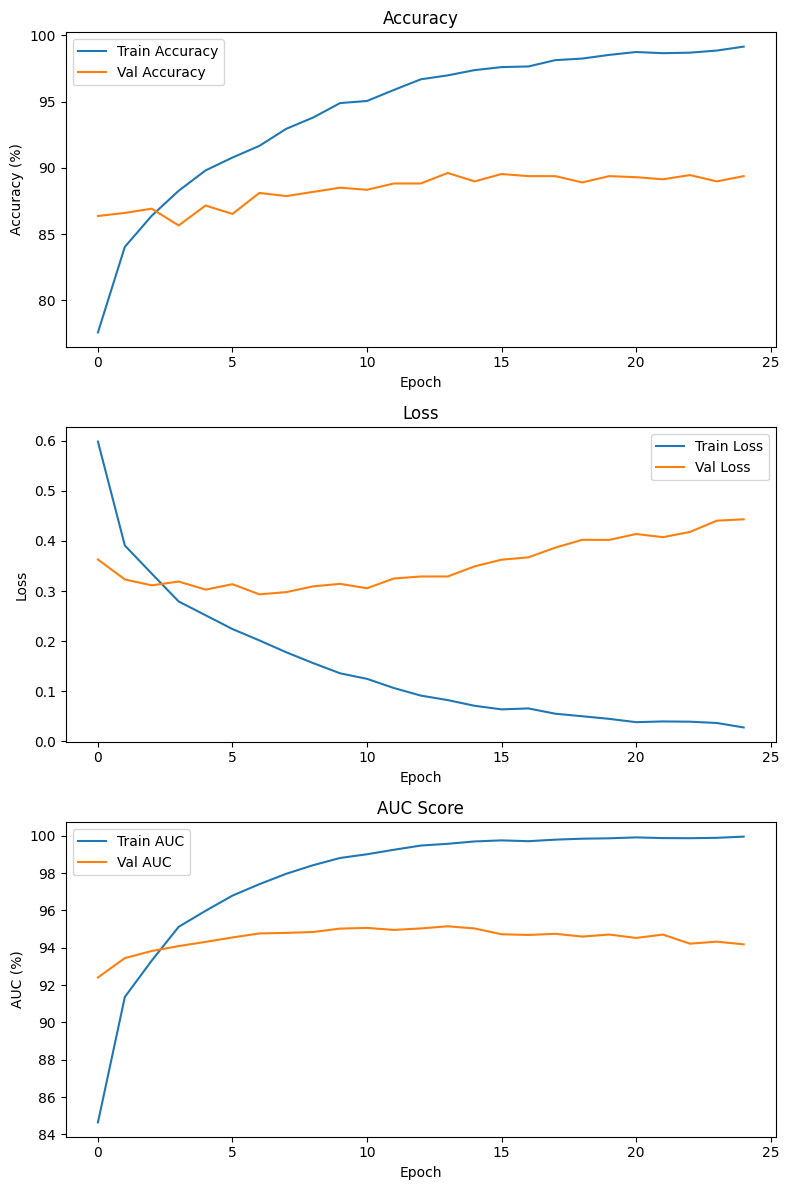

In [15]:
# Step 6: Plot training curves
plot_training_curves(history)